##### _

# **Pre-selection Task:** Alex's Notebook

### Imports

In [13]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.datasets import *
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, confusion_matrix, log_loss, roc_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import string
import shap

#Seed
np.random.seed(1889)

### Data Collection

In [14]:
# Import saved data
dataset_from_database = pd.read_csv("dataset_from_database.csv")
dataset_from_database.head()

# in production import from database
# dataset_from_database = collect_from_database("SELECT * FROM CLAIMS.DS_DATASET")

,Unnamed: 0,claim_status,age,height_cm,weight_kg,income,financial_hist_1,financial_hist_2,financial_hist_3,financial_hist_4,...,product_var_2,product_var_3,product_var_4,health_status,driving_record,previous_claim_rate,education_level,income level,n_dependents,employment_type
0,0,0,49,182,80,155292,1.408797,-0.573517,-0.464914,3.249624,...,0,A,0,3,2,1,2,3,1,0.0
1,1,0,55,185,86,169232,2.402368,1.135213,0.780797,3.075214,...,1,C,1,2,4,3,2,3,2,NaN
2,2,0,55,169,82,173856,-1.182139,0.337877,1.754185,1.932426,...,0,C,1,4,1,1,2,3,2,1.0
3,3,0,43,179,76,150264,1.107481,-1.123652,1.966727,-0.130857,...,1,D,1,4,1,1,0,3,2,NaN
4,4,0,56,167,86,118449,-0.985055,-0.604696,-0.650367,-1.329931,...,1,B,1,3,3,1,0,2,1,NaN


### Data Wrangling

In [15]:
dataset_from_database.drop(columns=['family_history_3', 'employment_type'], inplace=True)

In [16]:
non_numerical = ['gender', 'marital_status', 'occupation', 'location', 'prev_claim_rejected', 
                 'known_health_conditions', 'uk_residence', 'family_history_1', 'family_history_2', 
                 'family_history_4', 'family_history_5', 'product_var_1', 'product_var_2', 
                 'product_var_3', 'health_status', 'driving_record', 'previous_claim_rate', 
                 'education_level', 'income level', 'n_dependents']

for column in non_numerical:
    dataset_from_database[column] = dataset_from_database[column].astype('category')

### CV Model Training
- Cross Vaildation tests to see if I can improve the model performance - not sure if it's useful

In [17]:
# Separate the Dataframe into labels and features
X, y = dataset_from_database.drop('claim_status', axis=1), dataset_from_database[['claim_status']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1889)

# Build the evaluation set & metric list
eval_set = [(X_train, y_train)]
eval_metrics = ['auc', 'rmse', 'logloss']

In [18]:
parameter_gridSearch = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric=eval_metrics,
    early_stopping_rounds=15,
    enable_categorical=True,
    ),

    param_distributions={
    'n_estimators': stats.randint(50, 500),
    'learning_rate': stats.uniform(0.01, 0.75),
    'subsample': stats.uniform(0.25, 0.75),
    'max_depth': stats.randint(1, 8),
    'colsample_bytree': stats.uniform(0.1, 0.75),
    'min_child_weight': [1, 3, 5, 7, 9],
    },

    cv=5,
    n_iter=100,
    verbose=False,
    scoring='roc_auc',
)

parameter_gridSearch.fit(X_train, y_train, eval_set=eval_set, verbose=False)

print("Best parameters are: ", parameter_gridSearch.best_params_)

Best parameters are:  {'colsample_bytree': np.float64(0.35123017820831615), 'learning_rate': np.float64(0.07350099603081699), 'max_depth': 5, 'min_child_weight': 9, 'n_estimators': 236, 'subsample': np.float64(0.44091278361073943)}


In [19]:
model3 = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric=eval_metrics,
    early_stopping_rounds=15,
    enable_categorical=True,
    **parameter_gridSearch.best_params_ #Not sure what this does, from StackOverflow
    )

model3.fit(X_train, y_train, eval_set=eval_set, verbose=False)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,np.float64(0....3017820831615)
,device,None
,early_stopping_rounds,15
,enable_categorical,True
,eval_metric,"['auc', 'rmse', ...]"


### Model Evaluation

The Cohen Kappa score on the training data is: 0.9
The Cohen Kappa score on the test data is: 0.84

The accuracy on train dataset is:  0.9745
The accuracy on test dataset is:  0.959

Train confusion matrix:  [[6692   36]
 [ 168 1104]]

Test confusion matrix:  [[1655   14]
 [  68  263]]

ROC on train data:  0.9895111203344327
ROC on test data:  0.9644105503051016

Train log loss:  0.09143719924704868
Test log loss:  0.1392495634468559

F1 score is:  0.8651315789473685
Precision is:  0.9494584837545126
Recall is:  0.7945619335347432


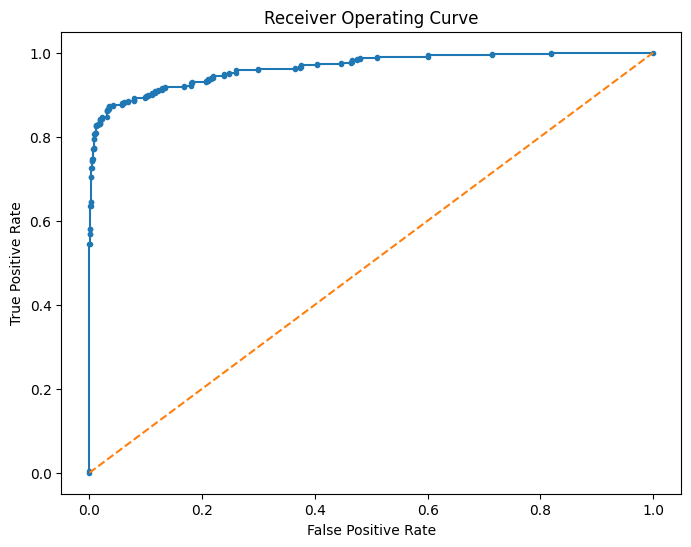

In [21]:
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, confusion_matrix, log_loss, roc_curve

train_class_preds2 = model3.predict(X_train)
test_class_preds2 = model3.predict(X_test)
train_prob_preds2 = model3.predict_proba(X_train)[:, 1]
test_prob_preds2 = model3.predict_proba(X_test)[:, 1]

y = np.array(y_train)
y = y.astype(int)
yhat = np.array(train_class_preds2)
yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)
kappa2 = round(cohen_kappa_score(yhat, y, weights='quadratic'), 2)
print(
f"The Cohen Kappa score on the training data is: {kappa2}"
)

y = np.array(y_test)
y = y.astype(int)
yhat = np.array(test_class_preds2)
yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)
kappa2 = round(cohen_kappa_score(yhat, y, weights='quadratic'), 2)
print(
f"The Cohen Kappa score on the test data is: {kappa2}"
)

print()
print("The accuracy on train dataset is: ", accuracy_score(y_train, train_class_preds2))
print("The accuracy on test dataset is: ", accuracy_score(y_test, test_class_preds2))

print()
print("Train confusion matrix: ", confusion_matrix(y_train, train_class_preds2))

print()
print("Test confusion matrix: ", confusion_matrix(y_test, test_class_preds2))

print()
print("ROC on train data: ", roc_auc_score(y_train, train_prob_preds2))
print("ROC on test data: ", roc_auc_score(y_test, test_prob_preds2))

print()
fpr, tpr, _ = roc_curve(y_test, test_prob_preds2)
random_fpr, random_tpr, _ = roc_curve(y_test, [0 for _ in range(len(y_test))])
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(fpr, tpr, marker='.', label='XGBoost')
plt.plot(random_fpr, random_tpr, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Curve")
print("Train log loss: ", log_loss(y_train, train_prob_preds2))
print("Test log loss: ", log_loss(y_test, test_prob_preds2))

print()
print("F1 score is: ", f1_score(y_test, test_class_preds2))
print("Precision is: ", precision_score(y_test, test_class_preds2))
print("Recall is: ", recall_score(y_test, test_class_preds2))

less performance in the ROC curve??

### Save the model

In [25]:
import joblib
model3.save_model("xgboost_model_optimised_with_cross_validation.json")